# Explore Obesity Data 01C - Poverty
Linking obesity to poverty via the obesity buckets.  
**Author:** Matthias Titze s0563413

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**File Pathes**

In [2]:
pwd

'/Users/matthiastitze/Uni HTW/DataScience/Repositories/datafriends_workshop/explore_data'

In [132]:
# File pathes for quick adjustment if places or directories change.
path_input = '00_data_input'
path_temp = '01_data_temp'
path_inter = '02_data_intermediate'
path_output = '03_data_output'
filename_atlas = 'food_atlas.xls'
filename_obesity_buckets_fips = 'obesity_buckets_fips.csv'
filename_obesity_buckets_fips = 'obesity_buckets_data.csv'
path_atlas = os.path.join(path_input, filename_atlas)
path_obesity_buckets_fips = os.path.join(path_inter, filename_obesity_buckets_fips)
path_obesity_buckets_data = os.path.join(path_inter, filename_obesity_buckets_fips)

## Refine Poverty Data  
Extract the required data from the original raw data source and clean or refine it.

**Extract Poverty Dataframe**  
We use data provided by:
**United States Department of Agriculture**  
https://www.ers.usda.gov/data-products/food-environment-atlas/data-access-and-documentation-downloads/#Current%20Version  
This data is provided as an Excel file with multiple sheets.
The values of the food atlas are collected for each US county which are identified by their FIPS-code.

In [8]:
# Load the socio-economic table from the food atlas data and extract the columns dealing with poverty.
df_social = pd.read_excel(path_atlas, sheet_name='SOCIOECONOMIC')
df_poverty = df_social[['FIPS', 'POVRATE15', 'CHILDPOVRATE15']].copy()

# Rename the columns to allow for better reading and referencing in the future.
df_poverty.rename(columns={'FIPS':'county_fips','POVRATE15':'PCT_poverty_rate_2015', \
                           'CHILDPOVRATE15':'PCT_poverty_rate_2015_children'}, inplace=True)

# Show some information about the dataframe we extracted so far.
df_poverty[:4]

,county_fips,PCT_poverty_rate_2015,PCT_poverty_rate_2015_children
0,1001,12.7,18.8
1,1003,12.9,19.6
2,1005,32.0,45.2
3,1007,22.2,29.3


**Store Result in File**  
Why not store this nice new dataframe as a .csv file for later use.

In [179]:
path_poverty_data = os.path.join(path_inter, 'poverty_refined_data.csv')
df_poverty.to_csv(path_poverty_data, index=False)

## Inspect Results  
Plot the dataframe data to get a visual understanding of the data. Also create a data description table.

**Poverty Data Description Frame**

In [177]:
ob_columns = ['PCT_poverty_rate_2015','PCT_poverty_rate_2015_children']
df_poverty_description = round(df_poverty[ob_columns].describe(), 3).transpose()
df_poverty_description

,count,mean,std,min,25%,50%,75%,max
PCT_poverty_rate_2015,3139.0,16.261,6.442,3.4,11.50,15.2,19.7,47.4
PCT_poverty_rate_2015_children,3139.0,23.239,9.364,3.3,16.25,22.3,29.1,61.6


In [180]:
path_poverty_description = os.path.join(path_inter, 'poverty_refined_decription.csv')
df_poverty_description.to_csv(path_poverty_description, index=False)

**Distribution Plots**

In [120]:
def plot_distribution(title, series, bins, color):
    sns.set_color_codes()
    sns.set(font_scale=1.4)
    plt.subplots(figsize=(20,8))
    plt.title(title) 
    sns.distplot(series.dropna(), bins=bins, color=color)

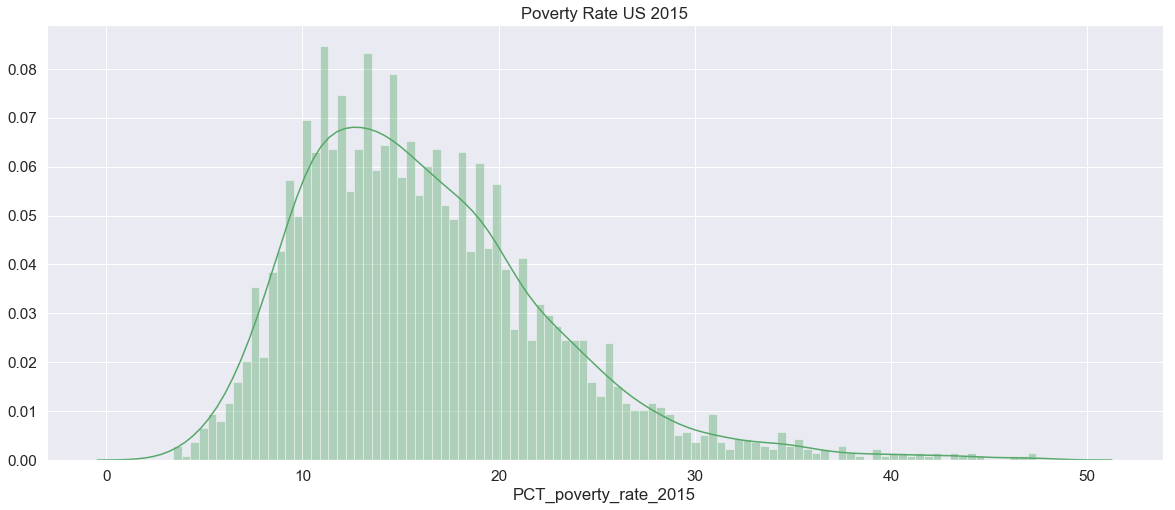

In [122]:
plot_distribution('Poverty Rate US 2015', df_poverty['PCT_poverty_rate_2015'], 100, 'g')

### Sorting Poverty Values into Obesity Groups
We now use the obesity groups we have formed and add the poverty data of the counties in each group.

In [125]:
df_obesity_bucket_fips = pd.read_csv(path_obesity_buckets_fips)

In [119]:
def get_poverty_values_for_fips_list(fips_list, column='PCT_poverty_rate_2015'):
    '''Gets a list of poverty values - one value for each code in the fips list.'''
    values_list = []
    
    for fips in fips_list:
        # Get the poverty value sub-dataframe for the county fips.
        df_poverty_value = df_poverty[df_poverty['county_fips']==int(fips)][column]
        # Extract the poverty value we need and add to list.
        poverty_value = df_poverty_value.iloc[0]
        values_list.append(poverty_value)
        
    return values_list

In [135]:
# We want to work on these columns of the refined obesity data.
columns = ['obesity_bucket','PCT_poverty_mean','PCT_poverty_median','PCT_poverty_stddev']
# Set up the layout of the new dataframe using the columns above.
df_poverty_bucket_data = pd.DataFrame([],columns=columns)
precision = 3

# Now analyse each obesity group (iterate through dataframe rows).
# Remenber, the fips (county) buckets group together counties whith a similiar obesity rate.
for i in range(len(df_obesity_bucket_fips.index)):
    
    # Extract the row's data fields.
    bucket_range = df_obesity_bucket_fips['bucket_range'].iloc[i]
    n_fips = df_obesity_bucket_fips['bucket_size'].iloc[i]
    fips_list_str = df_obesity_bucket_fips['county_fips'].iloc[i]
    
    # Calculate some standard statistical values for each obesity bucket.
    poverty_mean = 0
    poverty_median = 0
    poverty_stddev = 0
    
    if (n_fips != 0):
        fips_list = fips_list_str.split(', ')
        poverty_values = get_poverty_values_for_fips_list(fips_list)
        poverty_mean = round(np.nanmean(poverty_values), precision)
        poverty_median = round(np.nanmedian(poverty_values), precision)
        poverty_stddev = round(np.nanstd(poverty_values), precision)

    # Add a data row for the fips bucket to the new dataframe.
    row = {'obesity_bucket':bucket_range, \
           'PCT_poverty_mean':poverty_mean,'PCT_poverty_median':poverty_median,'PCT_poverty_stddev':poverty_stddev}
    df_poverty_bucket_data = df_poverty_bucket_data.append(row, ignore_index=True)

**Merge** the obesity group data with the poverty group data.

In [138]:
df_obesity_bucket_data = pd.read_csv(os.path.join(path_obesity_buckets_data))
df_obesity_poverty_data = pd.merge(df_obesity_bucket_data, df_poverty_bucket_data, how='inner', on='obesity_bucket')
df_obesity_poverty_data

,obesity_bucket,n_fips,PCT_obesity_mean,PCT_obesity_median,PCT_obesity_stddev,PCT_poverty_mean,PCT_poverty_median,PCT_poverty_stddev
0,%[10-12[,0,0.000,0.000,0.000,0,0,0
1,%[12-14[,36,12.992,13.025,0.318,9.533,8.8,2.374
2,%[14-16[,30,14.800,14.850,0.507,10.54,9.4,4.156
3,%[16-18[,85,16.979,17.025,0.645,11.5,11.35,3.877
4,%[18-20[,219,19.249,19.500,0.568,11.674,10.1,4.77
5,%[20-22[,414,21.117,21.200,0.559,14.213,12.9,6.878
6,%[22-24[,604,22.988,23.050,0.582,13.356,13,5.367
7,%[24-26[,1095,25.077,25.150,0.600,14.311,13.55,5.46
8,%[26-28[,3087,27.129,27.200,0.552,14.291,13.65,5.205
9,%[28-30[,4546,29.051,29.100,0.569,13.97,13.3,4.688


**Write** obesity vs. poverty buckets data **to file**.

In [139]:
path_obesity_poverty_data = os.path.join(path_inter, 'obesity_poverty_data.csv')
df_obesity_poverty_data.to_csv(os.path.join(path_obesity_poverty_data), index=False)

### Relating Poverty and Obesity Values  
Relate the obesity median value of each group to the respective median poverty value. This can show to some extend if obesity and poverty correlate.

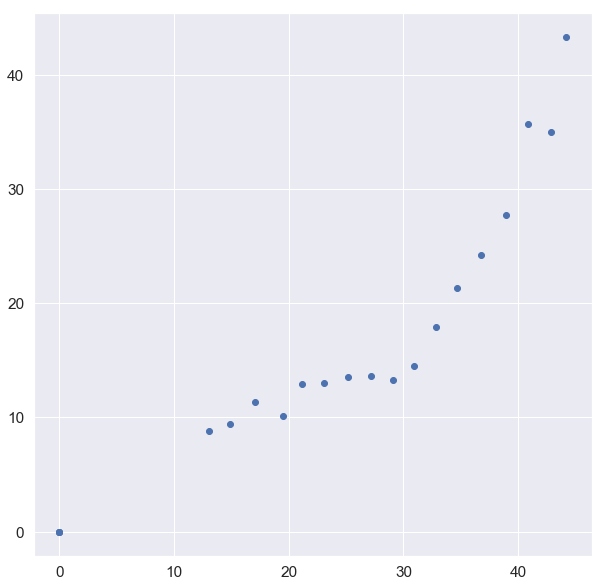

In [142]:
df_plt = df_obesity_poverty_data[['PCT_obesity_median','PCT_poverty_median']]
plt.rcParams['figure.figsize'] = [10,10]
plt.scatter(df_plt['PCT_obesity_median'].tolist(), df_plt['PCT_poverty_median'].tolist())

**Consider** that the different buckets (obesity groups) have vastly different sample sizes with the bulk of the data grouping towards the average. This is expressed in the scatter plot below by varying the plot point sizes.

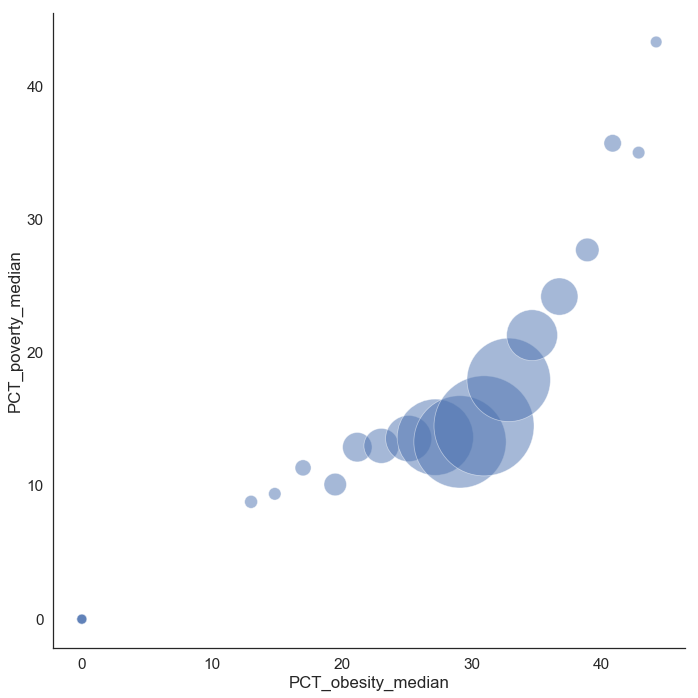

In [176]:
sns.set(style='white', font_scale=1.4)
sns.relplot(x='PCT_obesity_median', y='PCT_poverty_median', size='n_fips', data=df_obesity_poverty_data,
            sizes=(100, 10000), alpha=.5, palette='muted', height=10, legend=False)